In [37]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import plot_confusion_matrix

from neo4j import GraphDatabase

pd.options.display.max_columns = 50
pd.options.display.max_rows = 500

In [2]:
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, parameters=None, db=None):
        
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

In [3]:
uri = 'bolt://100.24.20.48:7687'
user = 'neo4j'
pwd = 'torque-trip-city'

conn = Neo4jConnection(uri=uri, user=user, pwd=pwd)
conn.query("MATCH (n) RETURN COUNT(n)")

[<Record COUNT(n)=281136>]

In [4]:
%%time

query = """MATCH (u:User)-[:POSTED]->(t:Tweet)
           RETURN u.user_key AS user_key,
                  u.id AS u_id,
                  u.name AS name,
                  u.screen_name AS screen_name,
                  u.is_troll AS is_troll,
                  u.created_at AS u_created_at,
                  u.favourites_count AS u_favourites_count,
                  u.followers_count AS followers_count,
                  u.statuses_count AS statuses_count,
                  u.lang AS lang,
                  u.location AS location,
                  u.time_zone AS time_zone,
                  u.verified AS verified,
                  u.description AS description,
                  t.id AS t_id,
                  t.created_at AS t_created_at,
                  t.text AS text,
                  t.favorite_count AS t_favorite_count,
                  t.retweet_count AS retweet_count,
                  t.retweeted AS retweeted
"""

tweets_df = pd.DataFrame([dict(_) for _ in conn.query(query)])
tweets_df.head()

CPU times: user 18.7 s, sys: 681 ms, total: 19.4 s
Wall time: 34.5 s


,user_key,u_id,name,screen_name,is_troll,u_created_at,u_favourites_count,followers_count,statuses_count,lang,location,time_zone,verified,description,t_id,t_created_at,text,t_favorite_count,retweet_count,retweeted
0,scottgohard,100345056,#Ezekiel2517✨...,SCOTTGOHARD,1,Tue Dec 29 23:15:22 +0000 2009,2774.0,1053.0,31858.0,en,still ⬆️Block⤵️Corner⬇️street,,False,CELEBRITY TRAINER ✨#424W147th✨ #CrossfitCoach ...,764189043152199680,1.471032e+12,Salute brother @iJesseWilliams https://t.co/7...,0.0,0.0,False
1,scottgohard,100345056,#Ezekiel2517✨...,SCOTTGOHARD,1,Tue Dec 29 23:15:22 +0000 2009,2774.0,1053.0,31858.0,en,still ⬆️Block⤵️Corner⬇️street,,False,CELEBRITY TRAINER ✨#424W147th✨ #CrossfitCoach ...,776056376414068738,1.473861e+12,facts https://t.co/OuTm9AdMp3,0.0,0.0,False
2,scottgohard,100345056,#Ezekiel2517✨...,SCOTTGOHARD,1,Tue Dec 29 23:15:22 +0000 2009,2774.0,1053.0,31858.0,en,still ⬆️Block⤵️Corner⬇️street,,False,CELEBRITY TRAINER ✨#424W147th✨ #CrossfitCoach ...,784822121818185728,1.475951e+12,"@eddiebellz not ""mutt"" @realDonaldTrump",0.0,0.0,False
3,scottgohard,100345056,#Ezekiel2517✨...,SCOTTGOHARD,1,Tue Dec 29 23:15:22 +0000 2009,2774.0,1053.0,31858.0,en,still ⬆️Block⤵️Corner⬇️street,,False,CELEBRITY TRAINER ✨#424W147th✨ #CrossfitCoach ...,780602260401299456,NaN,,NaN,NaN,None
4,scottgohard,100345056,#Ezekiel2517✨...,SCOTTGOHARD,1,Tue Dec 29 23:15:22 +0000 2009,2774.0,1053.0,31858.0,en,still ⬆️Block⤵️Corner⬇️street,,False,CELEBRITY TRAINER ✨#424W147th✨ #CrossfitCoach ...,791056262343655425,1.477437e+12,RT @JohnSmithChgo: @AwooMAGA @kushkandy95 @PWM...,0.0,0.0,False


In [5]:
tweets_df.shape

(200833, 20)

In [45]:
tweets_df.loc[tweets_df['is_troll'] == 0]

,user_key,u_id,name,screen_name,is_troll,u_created_at,u_favourites_count,followers_count,statuses_count,lang,location,time_zone,verified,description,t_id,t_created_at,text,t_favorite_count,retweet_count,retweeted


In [7]:
res = tweets_df[[isinstance(value, str) for value in tweets_df['is_troll']]]
print(len(res))

0


In [8]:
%%time

query = """MATCH (t:Tweet)-[:HAS_TAG]->(h:Hashtag)
           RETURN t.id AS t_id,
                  COLLECT(h.tag) AS tags
"""

hashtags_df = pd.DataFrame([dict(_) for _ in conn.query(query)])
hashtags_df.head()

CPU times: user 4.49 s, sys: 161 ms, total: 4.65 s
Wall time: 14.5 s


,t_id,tags
0,836230963667480576,[thingsdonebymistake]
1,836227574128861184,[thingsdonebymistake]
2,836227673143771136,[thingsdonebymistake]
3,836221435249111041,[thingsdonebymistake]
4,836228095656919040,[thingsdonebymistake]


In [9]:
hashtags_df.shape

(86719, 2)

In [10]:
%%time

query = """MATCH (t:Tweet)-[:MENTIONS]->(u:User)
           RETURN t.id AS t_id,
                  t.text,
                  COLLECT(u.user_key) AS user_mentions
"""

mentions_df = pd.DataFrame([dict(_) for _ in conn.query(query)])
mentions_df.head()

CPU times: user 2.31 s, sys: 85.1 ms, total: 2.39 s
Wall time: 6.2 s


,t_id,t.text,user_mentions
0,795984497967824897,"RT @SCOTTGOHARD: ""you rolling like trump?...ya...","[scottgohard, raekwon]"
1,766661714104422400,RT @JeffreyKahunas: Mysterious murders are not...,[jeffreykahunas]
2,772045505857716224,@JeffreyKahunas Only a blind and dumb fool wou...,[jeffreykahunas]
3,774319033470558208,@WesternWindWes #HillaryClinton is an evil!,[westernwindwes]
4,765196937960235008,RT @IlikeBIGbuttand: Even #ChildrenThinkThat T...,[ilikebigbuttand]


In [11]:
mentions_df.shape

(39514, 3)

In [12]:
%%time

query = """MATCH (t1:Tweet)-[:IN_REPLY_TO]->(t2:Tweet)
           RETURN t2.id AS t_id,
                  COLLECT(t1.id) AS reply_to
"""

replies_df = pd.DataFrame([dict(_) for _ in conn.query(query)])
replies_df.head()

CPU times: user 46.4 ms, sys: 0 ns, total: 46.4 ms
Wall time: 764 ms


,t_id,reply_to
0,763800602837123072,[763800657719545856]
1,759506712516784128,"[759506924903751680, 759507042205786112]"
2,773616523990761472,[773616605259595776]
3,759164202611306496,[759165124716429312]
4,793874305511780352,[793874529017880577]


In [13]:
replies_df.shape

(516, 2)

In [14]:
%%time

query = """MATCH (t:Tweet)-[:HAS_LINK]->(u:URL)
           WHERE u.expanded_url <> ""
           RETURN t.id AS t_id,
                  COLLECT(u.expanded_url) AS urls
"""

url_df = pd.DataFrame([dict(_) for _ in conn.query(query)])
url_df.head()

CPU times: user 1.36 s, sys: 31.6 ms, total: 1.39 s
Wall time: 3.55 s


,t_id,urls
0,777594647875059712,[http://ln.is/twitchy.com/loriz-31/3yafU]
1,782408661389840384,[https://twitter.com/i/web/status/782408661389...
2,777859822679158784,[http://freedomoutpost.com/2013/02/the-use-of-...
3,781999544502521857,[http://www.informationliberation.com/?id=55568]
4,777238119166775297,[https://twitter.com/Harlan/status/77714580969...


In [15]:
url_df.shape

(25381, 2)

In [16]:
%%time

query = """MATCH (t1:Tweet)-[:RETWEETED]->(t2:Tweet)
           RETURN t1.id AS t_id,
                  COLLECT(t2.id) AS retweet
"""

retweets_df = pd.DataFrame([dict(_) for _ in conn.query(query)])
retweets_df.head()

CPU times: user 2.18 s, sys: 89.1 ms, total: 2.27 s
Wall time: 5.43 s


,t_id,retweet
0,760786317374545920,[760628814871310337]
1,784313832487256064,[784310979710492672]
2,777594647875059712,[777591478206029824]
3,785586729579196416,[785326419509411840]
4,795661161282891776,[795463782671798272]


In [17]:
how = 'left'

rtt_df = pd.merge(left=tweets_df, right=mentions_df, how=how, on='t_id', suffixes=('_left','_right'))
rtt_df = pd.merge(left=rtt_df, right=hashtags_df, how=how, on='t_id', suffixes=('_left','_right'))
rtt_df = pd.merge(left=rtt_df, right=replies_df, how=how, on='t_id', suffixes=('_left','_right'))
rtt_df = pd.merge(left=rtt_df, right=url_df, how=how, on='t_id', suffixes=('_left','_right'))
rtt_df = pd.merge(left=rtt_df, right=retweets_df, how=how, on='t_id', suffixes=('_left','_right'))
rtt_df.head()

,user_key,u_id,name,screen_name,is_troll,u_created_at,u_favourites_count,followers_count,statuses_count,lang,location,time_zone,verified,description,t_id,t_created_at,text,t_favorite_count,retweet_count,retweeted,t.text,user_mentions,tags,reply_to,urls,retweet
0,scottgohard,100345056,#Ezekiel2517✨...,SCOTTGOHARD,1,Tue Dec 29 23:15:22 +0000 2009,2774.0,1053.0,31858.0,en,still ⬆️Block⤵️Corner⬇️street,,False,CELEBRITY TRAINER ✨#424W147th✨ #CrossfitCoach ...,764189043152199680,1.471032e+12,Salute brother @iJesseWilliams https://t.co/7...,0.0,0.0,False,Salute brother @iJesseWilliams https://t.co/7...,[ijessewilliams],NaN,NaN,[https://twitter.com/ijessewilliams/status/764...,NaN
1,scottgohard,100345056,#Ezekiel2517✨...,SCOTTGOHARD,1,Tue Dec 29 23:15:22 +0000 2009,2774.0,1053.0,31858.0,en,still ⬆️Block⤵️Corner⬇️street,,False,CELEBRITY TRAINER ✨#424W147th✨ #CrossfitCoach ...,776056376414068738,1.473861e+12,facts https://t.co/OuTm9AdMp3,0.0,0.0,False,NaN,NaN,NaN,NaN,[https://twitter.com/abc7/status/7759306333861...,NaN
2,scottgohard,100345056,#Ezekiel2517✨...,SCOTTGOHARD,1,Tue Dec 29 23:15:22 +0000 2009,2774.0,1053.0,31858.0,en,still ⬆️Block⤵️Corner⬇️street,,False,CELEBRITY TRAINER ✨#424W147th✨ #CrossfitCoach ...,784822121818185728,1.475951e+12,"@eddiebellz not ""mutt"" @realDonaldTrump",0.0,0.0,False,"@eddiebellz not ""mutt"" @realDonaldTrump",[realdonaldtrump],NaN,NaN,NaN,NaN
3,scottgohard,100345056,#Ezekiel2517✨...,SCOTTGOHARD,1,Tue Dec 29 23:15:22 +0000 2009,2774.0,1053.0,31858.0,en,still ⬆️Block⤵️Corner⬇️street,,False,CELEBRITY TRAINER ✨#424W147th✨ #CrossfitCoach ...,780602260401299456,NaN,,NaN,NaN,None,NaN,NaN,NaN,[780607504128638976],NaN,NaN
4,scottgohard,100345056,#Ezekiel2517✨...,SCOTTGOHARD,1,Tue Dec 29 23:15:22 +0000 2009,2774.0,1053.0,31858.0,en,still ⬆️Block⤵️Corner⬇️street,,False,CELEBRITY TRAINER ✨#424W147th✨ #CrossfitCoach ...,791056262343655425,1.477437e+12,RT @JohnSmithChgo: @AwooMAGA @kushkandy95 @PWM...,0.0,0.0,False,RT @JohnSmithChgo: @AwooMAGA @kushkandy95 @PWM...,"[jsavite, johnsmithchgo, kushkandy95, awoomaga...",NaN,NaN,NaN,[791055623240708096]


In [18]:
rtt_df.shape

(200833, 26)

In [19]:
rtt_df.to_csv('./rtt2.csv', header=True, index=False)

In [24]:
res = rtt_df[[isinstance(value, str) for value in rtt_df['is_troll']]]
print(len(res))

0


In [26]:
res = rtt_df[[isinstance(value, str) for value in rtt_df['is_troll']]]
print(len(res))

0


In [27]:
def has_value(row):

    if str(row) == 'NaN' or str(row) == 'nan':         # In these cases row is a float
        #print(row, type(row), "NOOOO")
        return 0
    else:
        #print(row, type(row), 'yes')
        return 1        

#rtt_df = rtt_orig_df
rtt_df['has_location'] = rtt_df['location'].map(has_value)
rtt_df['has_timezone'] = rtt_df['time_zone'].map(has_value)
rtt_df['has_description'] = rtt_df['description'].map(has_value)
rtt_df['has_mentions'] = rtt_df['user_mentions'].map(has_value)
rtt_df['has_tags'] = rtt_df['tags'].map(has_value)
rtt_df['has_reply_to'] = rtt_df['reply_to'].map(has_value)
rtt_df['has_url'] = rtt_df['urls'].map(has_value)
rtt_df['is_retweet'] = rtt_df['retweet'].map(has_value)
rtt_df = rtt_df.drop(['location', 'time_zone', 'description', 'user_mentions', 'tags', 'reply_to', 'urls', 'text', 't.text', 'retweet'], axis=1)
rtt_df.head()

,user_key,u_id,name,screen_name,is_troll,u_created_at,u_favourites_count,followers_count,statuses_count,lang,verified,t_id,t_created_at,t_favorite_count,retweet_count,retweeted,has_location,has_timezone,has_description,has_mentions,has_tags,has_reply_to,has_url,is_retweet
0,scottgohard,100345056,#Ezekiel2517✨...,SCOTTGOHARD,1,Tue Dec 29 23:15:22 +0000 2009,2774.0,1053.0,31858.0,en,False,764189043152199680,1.471032e+12,0.0,0.0,False,1,1,1,1,0,0,1,0
1,scottgohard,100345056,#Ezekiel2517✨...,SCOTTGOHARD,1,Tue Dec 29 23:15:22 +0000 2009,2774.0,1053.0,31858.0,en,False,776056376414068738,1.473861e+12,0.0,0.0,False,1,1,1,0,0,0,1,0
2,scottgohard,100345056,#Ezekiel2517✨...,SCOTTGOHARD,1,Tue Dec 29 23:15:22 +0000 2009,2774.0,1053.0,31858.0,en,False,784822121818185728,1.475951e+12,0.0,0.0,False,1,1,1,1,0,0,0,0
3,scottgohard,100345056,#Ezekiel2517✨...,SCOTTGOHARD,1,Tue Dec 29 23:15:22 +0000 2009,2774.0,1053.0,31858.0,en,False,780602260401299456,NaN,NaN,NaN,None,1,1,1,0,0,1,0,0
4,scottgohard,100345056,#Ezekiel2517✨...,SCOTTGOHARD,1,Tue Dec 29 23:15:22 +0000 2009,2774.0,1053.0,31858.0,en,False,791056262343655425,1.477437e+12,0.0,0.0,False,1,1,1,1,0,0,0,1


In [28]:
res = rtt_df[[isinstance(value, str) for value in rtt_df['is_troll']]]
print(len(res))

0


In [29]:
rtt_df.shape

(200833, 24)

In [30]:
def convert_true_false(row):

    if str(row) == 'False' or str(row) == 'NaN' or str(row) == 'nan':
        return 0
    else:
        return 1


rtt_df2 = rtt_df
rtt_df2['is_verified'] = rtt_df['verified'].map(convert_true_false)
rtt_df2['is_retweeted'] = rtt_df['retweeted'].map(convert_true_false)
rtt_df2 = rtt_df2.drop(['verified', 'retweeted'], axis=1)
rtt_df2.head()

,user_key,u_id,name,screen_name,is_troll,u_created_at,u_favourites_count,followers_count,statuses_count,lang,t_id,t_created_at,t_favorite_count,retweet_count,has_location,has_timezone,has_description,has_mentions,has_tags,has_reply_to,has_url,is_retweet,is_verified,is_retweeted
0,scottgohard,100345056,#Ezekiel2517✨...,SCOTTGOHARD,1,Tue Dec 29 23:15:22 +0000 2009,2774.0,1053.0,31858.0,en,764189043152199680,1.471032e+12,0.0,0.0,1,1,1,1,0,0,1,0,0,0
1,scottgohard,100345056,#Ezekiel2517✨...,SCOTTGOHARD,1,Tue Dec 29 23:15:22 +0000 2009,2774.0,1053.0,31858.0,en,776056376414068738,1.473861e+12,0.0,0.0,1,1,1,0,0,0,1,0,0,0
2,scottgohard,100345056,#Ezekiel2517✨...,SCOTTGOHARD,1,Tue Dec 29 23:15:22 +0000 2009,2774.0,1053.0,31858.0,en,784822121818185728,1.475951e+12,0.0,0.0,1,1,1,1,0,0,0,0,0,0
3,scottgohard,100345056,#Ezekiel2517✨...,SCOTTGOHARD,1,Tue Dec 29 23:15:22 +0000 2009,2774.0,1053.0,31858.0,en,780602260401299456,NaN,NaN,NaN,1,1,1,0,0,1,0,0,0,1
4,scottgohard,100345056,#Ezekiel2517✨...,SCOTTGOHARD,1,Tue Dec 29 23:15:22 +0000 2009,2774.0,1053.0,31858.0,en,791056262343655425,1.477437e+12,0.0,0.0,1,1,1,1,0,0,0,1,0,0


In [31]:
res = rtt_df2[[isinstance(value, str) for value in rtt_df2['is_troll']]]
print(len(res))
print(rtt_df2.shape)

0
(200833, 24)


In [32]:
rtt_df2['lang'].unique()

array(['en', 'ru', 'id', '', 'de', 'es', 'fr'], dtype=object)

In [33]:
def language_category(row):

    if row == 'en':
        return 1
    elif row == 'ru':
        return 2
    elif row == 'id':
        return 3
    elif row == 'de':
        return 4
    elif row == 'es':
        return 5
    elif row == 'fr':
        return 6
    else:
        return 0


rtt_df3 = rtt_df2
rtt_df3['lang_category'] = rtt_df3['lang'].map(language_category)
rtt_df3 = rtt_df3.drop(['lang'], axis=1)
rtt_df3.head()

,user_key,u_id,name,screen_name,is_troll,u_created_at,u_favourites_count,followers_count,statuses_count,t_id,t_created_at,t_favorite_count,retweet_count,has_location,has_timezone,has_description,has_mentions,has_tags,has_reply_to,has_url,is_retweet,is_verified,is_retweeted,lang_category
0,scottgohard,100345056,#Ezekiel2517✨...,SCOTTGOHARD,1,Tue Dec 29 23:15:22 +0000 2009,2774.0,1053.0,31858.0,764189043152199680,1.471032e+12,0.0,0.0,1,1,1,1,0,0,1,0,0,0,1
1,scottgohard,100345056,#Ezekiel2517✨...,SCOTTGOHARD,1,Tue Dec 29 23:15:22 +0000 2009,2774.0,1053.0,31858.0,776056376414068738,1.473861e+12,0.0,0.0,1,1,1,0,0,0,1,0,0,0,1
2,scottgohard,100345056,#Ezekiel2517✨...,SCOTTGOHARD,1,Tue Dec 29 23:15:22 +0000 2009,2774.0,1053.0,31858.0,784822121818185728,1.475951e+12,0.0,0.0,1,1,1,1,0,0,0,0,0,0,1
3,scottgohard,100345056,#Ezekiel2517✨...,SCOTTGOHARD,1,Tue Dec 29 23:15:22 +0000 2009,2774.0,1053.0,31858.0,780602260401299456,NaN,NaN,NaN,1,1,1,0,0,1,0,0,0,1,1
4,scottgohard,100345056,#Ezekiel2517✨...,SCOTTGOHARD,1,Tue Dec 29 23:15:22 +0000 2009,2774.0,1053.0,31858.0,791056262343655425,1.477437e+12,0.0,0.0,1,1,1,1,0,0,0,1,0,0,1


In [34]:
res = rtt_df3[[isinstance(value, str) for value in rtt_df3['is_troll']]]
print(len(res))
print(rtt_df3.shape)

0
(200833, 24)


In [35]:
rtt_df3.isna().sum()

user_key                   0
u_id                       0
name                       0
screen_name                0
is_troll                   0
u_created_at               0
u_favourites_count     17278
followers_count        17278
statuses_count         17278
t_id                       0
t_created_at              21
t_favorite_count      142782
retweet_count         142782
has_location               0
has_timezone               0
has_description            0
has_mentions               0
has_tags                   0
has_reply_to               0
has_url                    0
is_retweet                 0
is_verified                0
is_retweeted               0
lang_category              0
dtype: int64

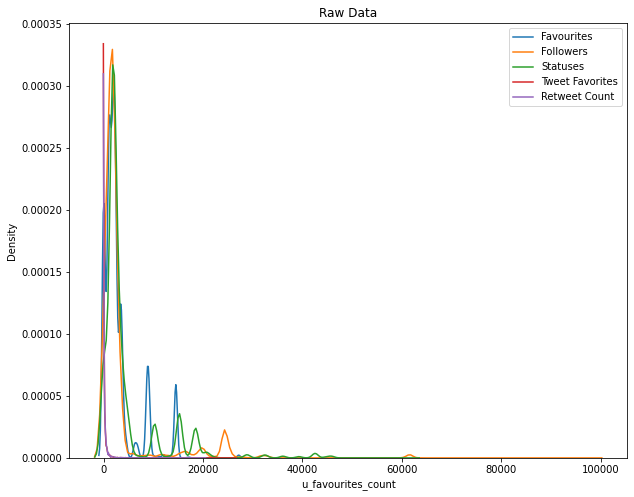

In [38]:
rtt_nonzero_df = rtt_df3.fillna(0.0)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Raw Data')
#ax1.set(xlim = (-2.0, 2.0))
#ax1.get_legend()

sns.kdeplot(rtt_nonzero_df['u_favourites_count'], ax=ax1)
sns.kdeplot(rtt_nonzero_df['followers_count'], ax=ax1)
sns.kdeplot(rtt_nonzero_df['statuses_count'], ax=ax1)
sns.kdeplot(rtt_nonzero_df['t_favorite_count'], ax=ax1)
sns.kdeplot(rtt_nonzero_df['retweet_count'], ax=ax1)

plt.legend(labels = ['Favourites', 'Followers', 'Statuses', 'Tweet Favorites', 'Retweet Count'])

In [39]:
scaler = RobustScaler()

scaled_df = rtt_df3.fillna(0.0)
#scaled_df['is_troll'] = scaled_df['is_troll'].astype(str).astype(int)
scaled_df[['scaled_favourites_count', 'scaled_followers_count', 'scaled_statuses_count']] = scaler.fit_transform(scaled_df[['u_favourites_count', 'followers_count', 'statuses_count']])
scaled_df[['scaled_t_favorite_count', 'scaled_retweet_count']] = scaler.fit_transform(scaled_df[['t_favorite_count', 'retweet_count']])
scaled_df = scaled_df.drop(['u_favourites_count', 'followers_count', 'statuses_count', 't_favorite_count', 'retweet_count'], axis=1)
#scaled_df.head()
scaled_df.dtypes

user_key                    object
u_id                        object
name                        object
screen_name                 object
is_troll                     int64
u_created_at                object
t_id                        object
t_created_at               float64
has_location                 int64
has_timezone                 int64
has_description              int64
has_mentions                 int64
has_tags                     int64
has_reply_to                 int64
has_url                      int64
is_retweet                   int64
is_verified                  int64
is_retweeted                 int64
lang_category                int64
scaled_favourites_count    float64
scaled_followers_count     float64
scaled_statuses_count      float64
scaled_t_favorite_count    float64
scaled_retweet_count       float64
dtype: object

In [40]:
res = scaled_df[[isinstance(value, str) for value in scaled_df['is_troll']]]
print(len(res))
print(scaled_df.shape)

0
(200833, 24)


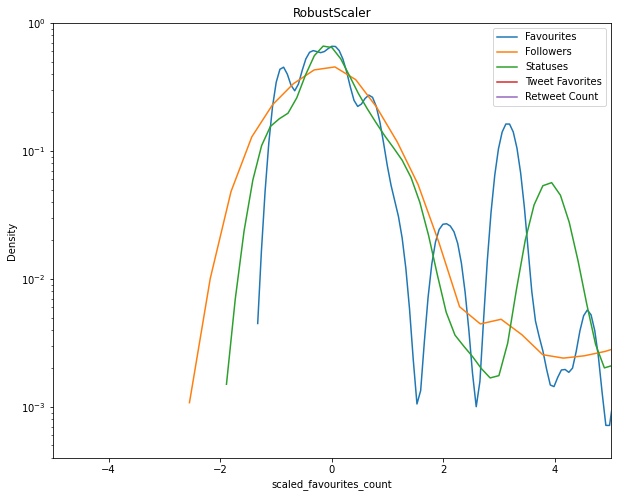

In [41]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('RobustScaler')
ax1.set(ylim = (0.0004, 1.0))
ax1.set(xlim = (-5.0, 5.0))
ax1.set_yscale('log')

sns.kdeplot(scaled_df['scaled_favourites_count'], ax=ax1)
sns.kdeplot(scaled_df['scaled_followers_count'], ax=ax1)
sns.kdeplot(scaled_df['scaled_statuses_count'], ax=ax1)
sns.kdeplot(scaled_df['scaled_t_favorite_count'], ax=ax1)
sns.kdeplot(scaled_df['scaled_retweet_count'], ax=ax1)

plt.legend(labels = ['Favourites', 'Followers', 'Statuses', 'Tweet Favorites', 'Retweet Count'])

In [42]:
def modeler(df, subset_features, k_folds=5, model='linear', show_matrix=True):

    acc_scores = []
    
    df['is_troll_int'] = df['is_troll'].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(scaled_df[subset_features], 
                                                        scaled_df['is_troll_int'], 
                                                        test_size=0.25,
                                                        random_state=42)
    X_train = X_train.values
    X_test = X_test.values
    y_train = y_train.values
    y_test = y_test.values

    print(y_train[0:5])
    
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    
    for i in range(0, k_folds):
        
        clf = svm.SVC(kernel='linear')
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        acc = accuracy_score(pred, y_test)
        acc_scores.append(acc)
    
    print('Accuracy scores: ', acc_scores)
    print('Mean accuracy: ', np.mean(acc_scores))
    
    if show_matrix:
        matrix = plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, normalize='true')
        plt.show(matrix)
        plt.show()
    
    return

In [43]:
subset_features = ['scaled_favourites_count', 'scaled_followers_count', 
                   'scaled_statuses_count', 'scaled_t_favorite_count', 
                   'scaled_retweet_count']

modeler(scaled_df, subset_features)

[1 1 1 1 1]
(150624, 5) (50209, 5) (150624,) (50209,)


ValueError: The number of classes has to be greater than one; got 1 class

In [44]:
scaled_df['is_troll'].min(), scaled_df['is_troll'].max()

(1, 1)